In [20]:
import numpy as np
import time
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import seaborn as sns
import os

In [23]:
TM = time.strftime('%d-%b-%Y-%H-%M-%S')

In [14]:
def plotCNNPerformanceMetrics(performance_file, scenario="all"):
    #performance_file = "../../results/opt-cnn-performance-metrics-summary-" + str(resolution) + "px.csv"
#     resolution = performance_file.split('-')[-1].split('px')[0]
    PERFORMANCE_PLOTS = "../../figures/performance-plots/"
    resolution = performance_file.split('-')[-12].split('px')[0]
    aug_technique = performance_file.split('-')[-7].split('px')[0] + '/'
    co = ["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"]
    if 'test' in performance_file:
        model_name = performance_file.split('-')[-16].split('px')[0]
    else:
        model_name = performance_file.split('-')[-14].split('px')[0]
    print(model_name)
    dfm = pd.read_csv(performance_file)
    num_epochs = dfm.epoch.max()
    #melted_df = dfm.melt(id_vars = ["epoch", "Scenario"], value_vars = ["loss", "accuracy", "val_loss", "val_accuracy"], var_name = "metric", value_name = "value")
    melted_df = dfm.melt(id_vars = ["epoch", "Scenario"], value_vars = ["loss", "accuracy", "val_loss", "val_accuracy", "val_f1", "val_precision", "val_recall"], var_name = "metric", value_name = "value")
    melted_df["metric_type"] = None
    melted_df["phase"] = "Validation"
    melted_df.loc[melted_df.metric.isin(["loss", "val_loss"]), "metric_type"] = "Loss"
    melted_df.loc[melted_df.metric.isin(["accuracy", "val_accuracy", "val_f1", "val_precision", "val_recall"]), "metric_type"] = "Performance"
    melted_df.loc[melted_df.metric.isin(["loss", "accuracy"]), "phase"] = "Training"
    #print(melted_df.metric.unique())
#     if not scenario=="all":
#         melted_df = melted_df.loc[melted_df.Scenario==scenario]
    
    sns.set_style("whitegrid")
    if not scenario=="all":
        g = sns.FacetGrid(melted_df, col="Scenario", row="metric_type", sharey = False, hue_kws = {"linestyle" : ["-","--"]})
    else:
        g = sns.FacetGrid(melted_df, col="Scenario", row="metric_type", col_order = co, sharey = False, hue_kws = {"linestyle" : ["-","--"]})
    g.map_dataframe(sns.lineplot, x = "epoch", y = "value", ci=None, hue = "metric", style="phase",  style_order=["Validation", "Training"], alpha=.85,
                    #palette= sns.color_palette("Set2", n_colors=8) 
                   )
    g.set_axis_labels("Epoch", "", fontsize = 16)
    g.add_legend(bbox_to_anchor=(1.02, .75), loc=2,fontsize=16) 
    ## Customize legend
    g._legend.texts[0].set_text("")
    g._legend.texts[1].set_text("Train. loss") #Data
    g._legend.texts[2].set_text("Test loss")
    g._legend.texts[3].set_text("")    
    g._legend.texts[4].set_text("")    
    g._legend.texts[5].set_text("")    
    g._legend.texts[6].set_text("Train. accuracy")    
    g._legend.texts[7].set_text("Test accuracy")    
    g._legend.texts[8].set_text("Avg. F1")    
    g._legend.texts[9].set_text("Avg. precision")    
    g._legend.texts[10].set_text("Avg. recall")    
    g._legend.legendHandles[4].set_linewidth(0)
    g._legend.legendHandles[5].set_linewidth(0)    
    g._legend.legendHandles[6].set_linestyle('--')    
    g._legend.legendHandles[1].set_linestyle('--')    

    # g._legend._legend_box.sep = 5
    axes = g.axes
    for row, axlist in enumerate(axes):
        if row==0:
            for col, axis in enumerate(axes[row]):
                print("base model ylimit set")
                axes[row, col].set_ylim(-0.05, 5)#.75                 
                if not('base') in model_name:
                    axes[row, col].set_ylim(0, 5)
                else: 
                    pass# print("base model ylimit set")
                    #axes[row, col].set_ylim(-0.05, 4)#.75 
                if 'base' not in model_name:
                    axes[row, col].set_xlim(1, num_epochs)
                else: #'base' in model_name:
                    if num_epochs % 3 == 0:
                        majors = []
                        for i in range(1,num_epochs+1,2):
                            majors.append(i)
                        axes[row, col].xaxis.set_major_locator(tkr.FixedLocator(majors))
                    elif num_epochs % 2 == 0:
                        axes[row, col].xaxis.set_major_locator(tkr.MultipleLocator(2))
                    else:
                        majors = []
                        for i in range(1,num_epochs+1):
                            majors.append(i)
                        axes[row, col].xaxis.set_major_locator(tkr.FixedLocator(majors))
                axes[row, col].set_title("Scenario: " + str(axes[row, col].title).split("Scenario = ")[1].split(")")[0].split("\'")[0],
                                        fontsize=16)
                if col != 0:
                    axes[row, col].get_yaxis().set_ticklabels([])
                else:
                    axes[row, col].set_ylabel("Loss", fontsize=16)
        elif row==1:
            for col, axis in enumerate(axes[row]):
                #axes[row, col].set_xlim(0, 1.05)
                axes[row, col].set_ylim(0, 1.05)
                if not("base") in model_name:
                    axes[row, col].set_xlim(1, num_epochs)
                axes[row, col].set_title("")
                if col != 0:
                    axes[row, col].get_yaxis().set_ticklabels([])
                else:
                    axes[row, col].set_ylabel("Performance", fontsize=16)
    g.fig.tight_layout()
    if not os.path.exists(PERFORMANCE_PLOTS):
        os.makedirs(PERFORMANCE_PLOTS)
    subdir = os.path.join(PERFORMANCE_PLOTS, aug_technique)
    if not os.path.exists(subdir):
        os.makedirs(subdir)
    exec_instance = os.path.join(subdir,TM+'/')
    if not os.path.exists(exec_instance):
        os.makedirs(exec_instance)
    if scenario != "all":
        g.savefig(exec_instance + model_name + "-" + scenario + "-performance-metrics-" + str(resolution) + "px-plot.png", dpi=180)
    else:
        g.savefig(exec_instance + model_name + "-performance-metrics-" + str(resolution) + "px-plot.png", dpi=180)
    return(dfm)

In [23]:
s.split('-')[-12].split('px')[0]

'336'

In [15]:
s = "../../results/test-opt-cnn-performance-metrics-summary-resnet50-w-336-px-h-336-px-occlusion_all-02-Mar-2022-02-45-11.csv"

In [19]:
s.split('-')[-14].split('px')[0]

'resnet50'

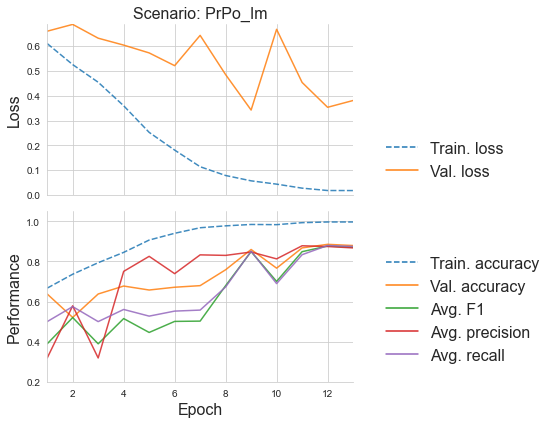

In [3]:
PERFORMANCE_FILE  = "../../results/opt-cnn-performance-metrics-summary-128px.csv"
d = plotCNNPerformanceMetrics(PERFORMANCE_FILE)

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,val_f1,val_recall,val_precision,Scenario,epoch
0,0,1.543852,0.642857,0.654235,0.669173,0.400901,0.500000,0.334586,PrPo_Im,1
1,1,0.784658,0.669173,0.634400,0.669173,0.400901,0.500000,0.334586,PrPo_Im,2
2,2,0.752994,0.627820,171.794434,0.669173,0.400901,0.500000,0.334586,PrPo_Im,3
3,3,0.791354,0.675752,137.696777,0.330827,0.248588,0.500000,0.165414,PrPo_Im,4
4,4,0.741272,0.646617,557.390808,0.669173,0.400901,0.500000,0.334586,PrPo_Im,5
...,...,...,...,...,...,...,...,...,...,...
195,195,0.549163,0.782895,3.972593,0.661654,0.265460,0.329588,0.222222,Pr_Po_Im,46
196,196,0.486690,0.803571,1.894289,0.661654,0.357849,0.371587,0.479024,Pr_Po_Im,47
197,197,0.488968,0.800752,2.035661,0.541353,0.344218,0.361679,0.360812,Pr_Po_Im,48
198,198,0.415347,0.835526,2.530274,0.669173,0.322492,0.357182,0.669251,Pr_Po_Im,49


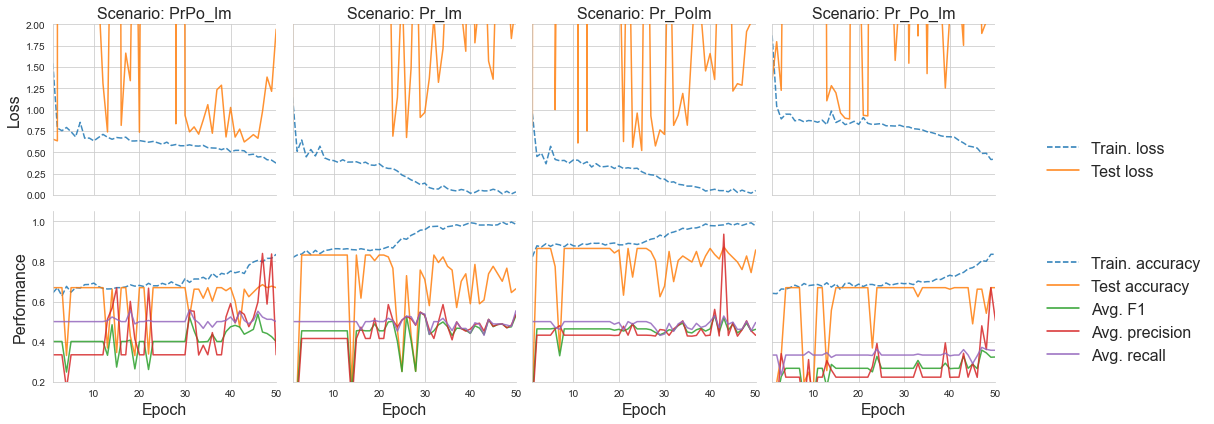

In [19]:
RESNET_PERFORMANCE_TESTING_MODE  = "../../results/test-opt-cnn-performance-metrics-summary-resnet50-w-252-px-h252-px-03-Aug-2021-16-17-45.csv"
plotCNNPerformanceMetrics(RESNET_PERFORMANCE_TESTING_MODE)

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,val_f1,val_recall,val_precision,Scenario,epoch
0,0,0.576029,0.800234,5.734849,0.831776,0.454082,0.500000,0.415888,Pr_Im,1
1,1,0.481418,0.836449,4.290155,0.831776,0.454082,0.500000,0.415888,Pr_Im,2
2,2,0.450905,0.850467,0.472767,0.803738,0.623807,0.616105,0.634783,Pr_Im,3
3,3,0.435029,0.842290,1.538803,0.831776,0.454082,0.500000,0.415888,Pr_Im,4
4,4,0.396904,0.843458,1.093681,0.467290,0.443776,0.591136,0.554478,Pr_Im,5
5,5,0.398808,0.857477,0.777197,0.831776,0.454082,0.500000,0.415888,Pr_Im,6
6,6,0.383682,0.853972,0.831945,0.831776,0.454082,0.500000,0.415888,Pr_Im,7
7,7,0.342482,0.858645,1.669446,0.831776,0.454082,0.500000,0.415888,Pr_Im,8
8,8,0.334808,0.858645,0.903521,0.831776,0.454082,0.500000,0.415888,Pr_Im,9
9,9,0.303007,0.872664,1.340428,0.831776,0.454082,0.500000,0.415888,Pr_Im,10


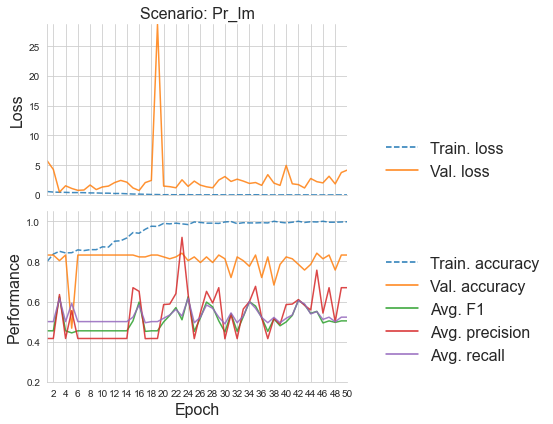

In [13]:
BASE_PERFORMANCE_TESTING_MODE_NON_OPT  = "../../results/test-opt-cnn-performance-metrics-summary-base-w-252-px-h252-px-03-Aug-2021-11-34-24.csv"
plotCNNPerformanceMetrics(BASE_PERFORMANCE_TESTING_MODE_NON_OPT)

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,val_f1,val_recall,val_precision,Scenario,epoch
0,0,0.780720,0.638158,6.312048,0.669173,0.400901,0.500000,0.334586,PrPo_Im,1
1,1,0.676411,0.661654,21.682978,0.669173,0.400901,0.500000,0.334586,PrPo_Im,2
2,2,0.610713,0.675752,3.918718,0.676692,0.424937,0.511364,0.837121,PrPo_Im,3
3,3,0.614819,0.686090,3.773045,0.669173,0.400901,0.500000,0.334586,PrPo_Im,4
4,4,0.596154,0.707707,2.877229,0.669173,0.400901,0.500000,0.334586,PrPo_Im,5
5,5,0.593588,0.681391,1.272687,0.669173,0.400901,0.500000,0.334586,PrPo_Im,6
6,6,0.585714,0.686090,2.928554,0.669173,0.400901,0.500000,0.334586,PrPo_Im,7
7,7,0.573273,0.702068,0.930102,0.631579,0.537441,0.540858,0.553050,PrPo_Im,8
8,8,0.563468,0.716165,2.526623,0.669173,0.400901,0.500000,0.334586,PrPo_Im,9
9,9,0.528047,0.734962,1.160329,0.669173,0.400901,0.500000,0.334586,PrPo_Im,10


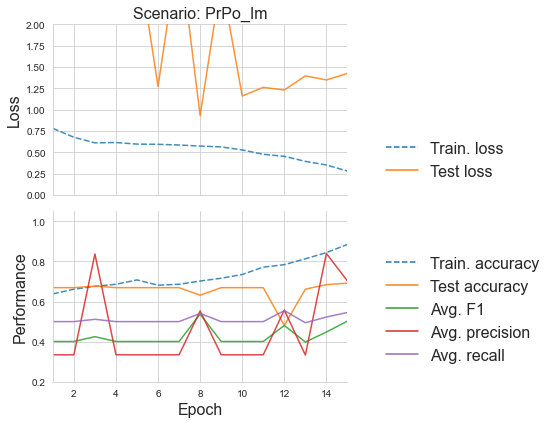

In [34]:
BASE_PERFORMANCE_TESTING_MODE_NON_OPT  = "../../results/test-opt-cnn-performance-metrics-summary-base-w-252-px-h252-px-06-Aug-2021-05-16-25.csv"
plotCNNPerformanceMetrics(BASE_PERFORMANCE_TESTING_MODE_NON_OPT)

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,val_f1,val_recall,val_precision,Scenario,epoch
0,0,0.970355,0.665414,0.717819,0.330827,0.248588,0.500000,0.165414,PrPo_Im,1
1,1,0.671890,0.680451,1.029241,0.669173,0.400901,0.500000,0.334586,PrPo_Im,2
2,2,0.672813,0.676692,4.844982,0.330827,0.248588,0.500000,0.165414,PrPo_Im,3
3,3,0.632192,0.681391,498.461456,0.330827,0.248588,0.500000,0.165414,PrPo_Im,4
4,4,0.688452,0.671053,325.482635,0.330827,0.248588,0.500000,0.165414,PrPo_Im,5
...,...,...,...,...,...,...,...,...,...,...
195,195,0.791611,0.697368,1.787463,0.669173,0.267267,0.333333,0.223058,Pr_Po_Im,46
196,196,0.793605,0.689850,1.173070,0.593985,0.293821,0.323106,0.275845,Pr_Po_Im,47
197,197,0.789091,0.681391,1.001484,0.639098,0.259939,0.318352,0.219638,Pr_Po_Im,48
198,198,0.780767,0.691729,1.119761,0.669173,0.267267,0.333333,0.223058,Pr_Po_Im,49


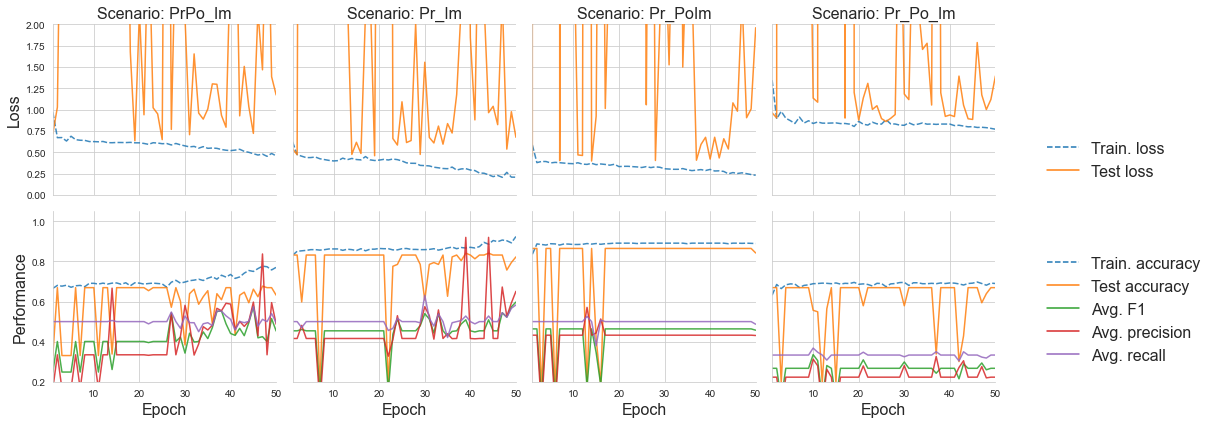

In [30]:
INCEPTION_TESTING_MODE  = "../../results/test-opt-cnn-performance-metrics-summary-inception_v3-w-252-px-h252-px-04-Aug-2021-21-20-17.csv"
plotCNNPerformanceMetrics(INCEPTION_TESTING_MODE)

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,val_f1,val_recall,val_precision,Scenario,epoch
0,0,1.543852,0.642857,0.654235,0.669173,0.400901,0.500000,0.334586,PrPo_Im,1
1,1,0.784658,0.669173,0.634400,0.669173,0.400901,0.500000,0.334586,PrPo_Im,2
2,2,0.752994,0.627820,171.794434,0.669173,0.400901,0.500000,0.334586,PrPo_Im,3
3,3,0.791354,0.675752,137.696777,0.330827,0.248588,0.500000,0.165414,PrPo_Im,4
4,4,0.741272,0.646617,557.390808,0.669173,0.400901,0.500000,0.334586,PrPo_Im,5
...,...,...,...,...,...,...,...,...,...,...
195,195,0.549163,0.782895,3.972593,0.661654,0.265460,0.329588,0.222222,Pr_Po_Im,46
196,196,0.486690,0.803571,1.894289,0.661654,0.357849,0.371587,0.479024,Pr_Po_Im,47
197,197,0.488968,0.800752,2.035661,0.541353,0.344218,0.361679,0.360812,Pr_Po_Im,48
198,198,0.415347,0.835526,2.530274,0.669173,0.322492,0.357182,0.669251,Pr_Po_Im,49


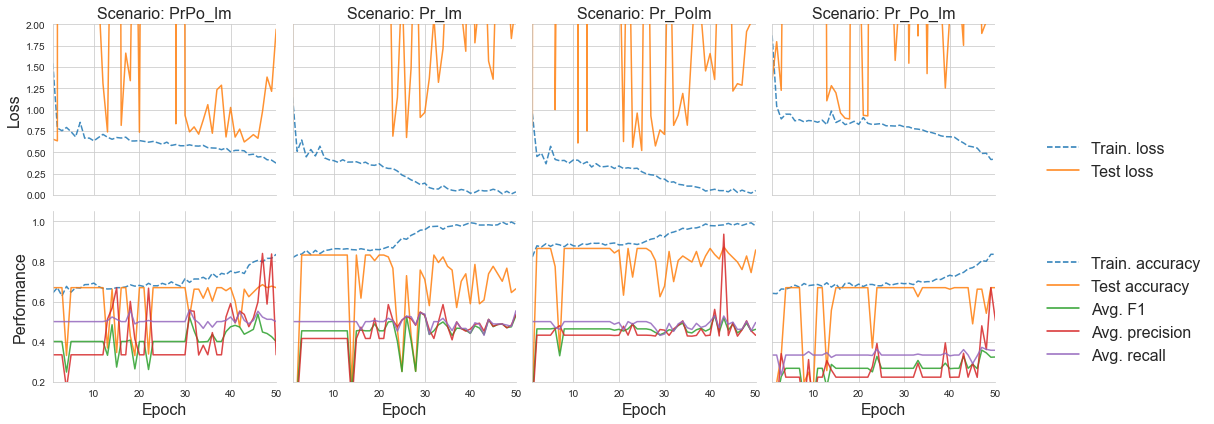

In [31]:
RESNET_TESTING_MODE  = "../../results/test-opt-cnn-performance-metrics-summary-resnet50-w-252-px-h252-px-03-Aug-2021-16-17-45.csv"
plotCNNPerformanceMetrics(RESNET_TESTING_MODE)

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,val_f1,val_recall,val_precision,Scenario,epoch
0,0,1.097863,0.649436,0.665594,0.669173,0.400901,0.5,0.334586,PrPo_Im,1
1,1,0.697754,0.656015,731.679504,0.330827,0.248588,0.5,0.165414,PrPo_Im,2
2,2,0.682798,0.675752,48.968445,0.669173,0.400901,0.5,0.334586,PrPo_Im,3
3,3,0.684195,0.668233,1068.964966,0.669173,0.400901,0.5,0.334586,PrPo_Im,4
4,4,0.678964,0.676692,5.459500,0.669173,0.400901,0.5,0.334586,PrPo_Im,5
5,5,0.655051,0.671053,163.302261,0.669173,0.400901,0.5,0.334586,PrPo_Im,6
6,6,0.659202,0.679511,131.188263,0.330827,0.248588,0.5,0.165414,PrPo_Im,7
7,7,0.627172,0.687030,0.651478,0.669173,0.400901,0.5,0.334586,PrPo_Im,8
8,8,0.665630,0.658835,0.666822,0.669173,0.400901,0.5,0.334586,PrPo_Im,9
9,9,0.646361,0.684211,0.676685,0.669173,0.400901,0.5,0.334586,PrPo_Im,10


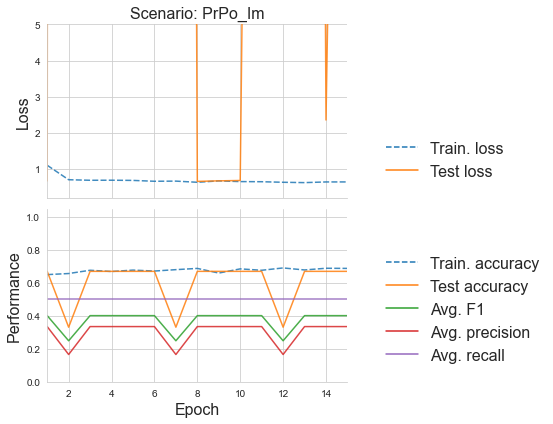

In [40]:
INCEPTION_PATIENCE_7_TESTING_MODE  = "../../results/test-opt-cnn-performance-metrics-summary-inception_v3-w-252-px-h252-px-patience-7-12-Aug-2021-18-43-18.csv"
plotCNNPerformanceMetrics(INCEPTION_PATIENCE_7_TESTING_MODE)

base model ylimit set


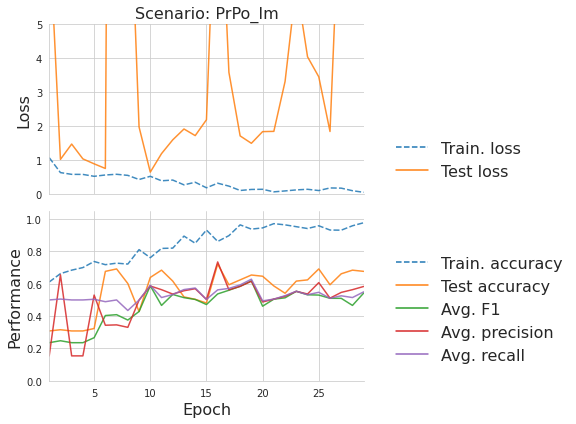

In [53]:
#RESNET_PATIENCE_7_TESTING_MODE  = "../../results/test-opt-cnn-performance-metrics-summary-resnet50-w-252-px-h252-px-patience-7-12-Aug-2021-16-55-48.csv"
RESNET_PATIENCE_10  = "../../results/opt-cnn-performance-metrics-summary-resnet50-w-336-px-h336-20-Aug-2021-05-31-07-px.csv"
#plotCNNPerformanceMetrics(RESNET_PATIENCE_7_TESTING_MODE)
gg = plotCNNPerformanceMetrics(RESNET_PATIENCE_10, scenario = "Pr_Im")

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,val_f1,val_recall,val_precision,Scenario,epoch
0,0,1.045355,0.597744,9.548343,0.669173,0.400901,0.500000,0.334586,PrPo_Im,1
1,1,0.697163,0.649436,3.841085,0.669173,0.400901,0.500000,0.334586,PrPo_Im,2
2,2,0.669132,0.649436,1.687887,0.676692,0.424937,0.511364,0.837121,PrPo_Im,3
3,3,0.666787,0.662594,0.934418,0.669173,0.421739,0.505746,0.585878,PrPo_Im,4
4,4,0.594769,0.693609,1.306892,0.676692,0.424937,0.511364,0.837121,PrPo_Im,5
...,...,...,...,...,...,...,...,...,...,...
56,56,0.039458,0.995301,0.915591,0.646617,0.261796,0.322097,0.220513,Pr_Po_Im,10
57,57,0.026857,0.994361,0.932426,0.639098,0.329831,0.351276,0.416667,Pr_Po_Im,11
58,58,0.022854,0.997180,1.202369,0.661654,0.266667,0.329588,0.223919,Pr_Po_Im,12
59,59,0.030378,0.993421,1.026827,0.571429,0.318527,0.339095,0.300611,Pr_Po_Im,13


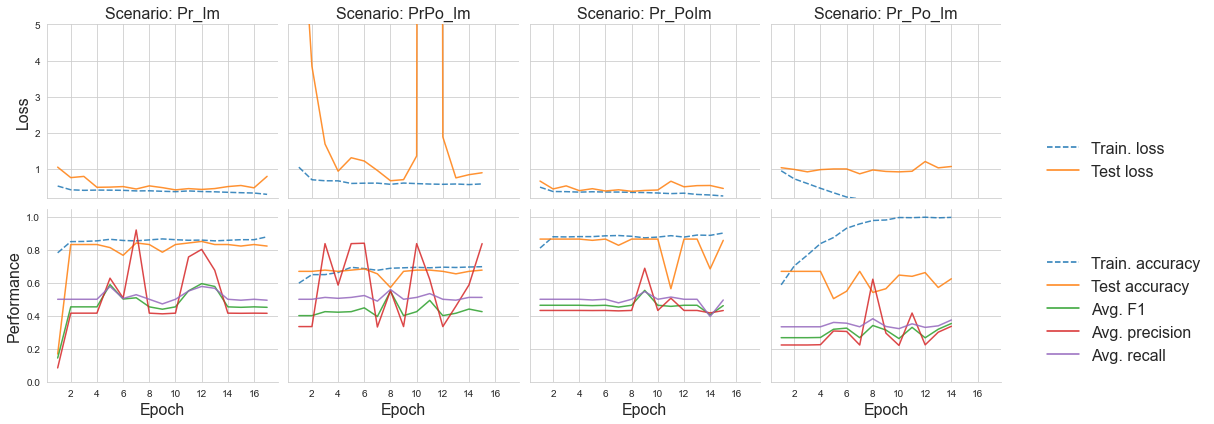

In [3]:
OPT_BASE_7_TESTING_MODE  = "../../results/opt-cnn-performance-metrics-summary-base-w-252-px-h252-16-Aug-2021-20-52-44-px.csv"
plotCNNPerformanceMetrics(OPT_BASE_7_TESTING_MODE)

base model ylimit set
base model ylimit set
base model ylimit set
base model ylimit set


,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,val_f1,val_recall,val_precision,Scenario,epoch
0,0,0.740773,0.544496,0.599490,0.851852,0.460000,0.500000,0.425926,Pr_Im,1
1,1,0.606847,0.677986,0.601273,0.851852,0.460000,0.500000,0.425926,Pr_Im,2
2,2,0.550174,0.724824,0.474556,0.851852,0.460000,0.500000,0.425926,Pr_Im,3
3,3,0.449907,0.826698,0.417567,0.851852,0.460000,0.500000,0.425926,Pr_Im,4
4,4,0.365429,0.861827,0.442166,0.851852,0.460000,0.500000,0.425926,Pr_Im,5
...,...,...,...,...,...,...,...,...,...,...
82,82,0.054212,0.979323,2.848562,0.676692,0.270270,0.326087,0.230769,Pr_Po_Im,20
83,83,0.057915,0.982143,4.503946,0.691729,0.272593,0.333333,0.230576,Pr_Po_Im,21
84,84,0.025375,0.990601,2.206462,0.639098,0.359543,0.385652,0.337459,Pr_Po_Im,22
85,85,0.013334,0.997180,2.135872,0.669173,0.350532,0.371014,0.345546,Pr_Po_Im,23


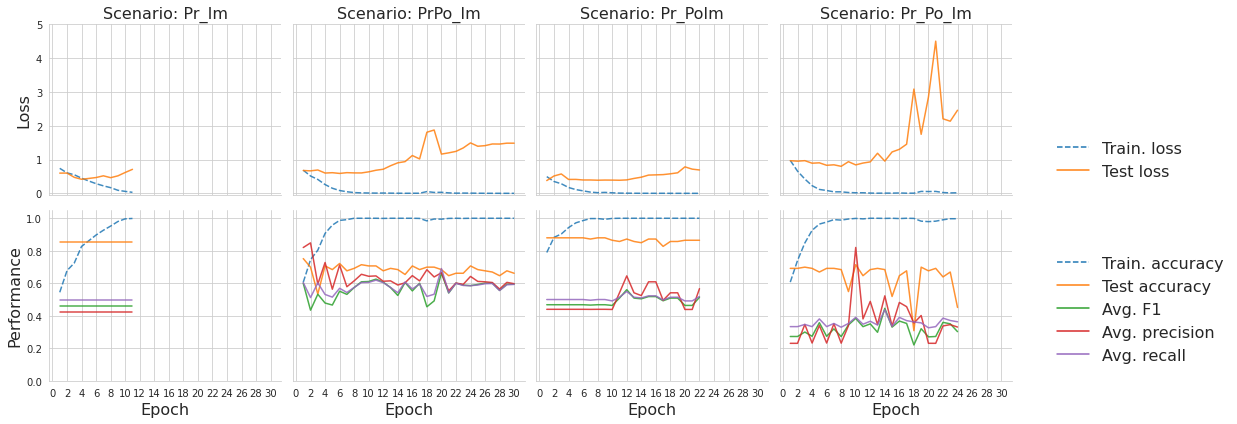

In [51]:
OPT_BASE_10  = "../../results/opt-cnn-performance-metrics-summary-base-w-336-px-h336-19-Aug-2021-16-40-02-px.csv"
plotCNNPerformanceMetrics(OPT_BASE_10)

base model ylimit set


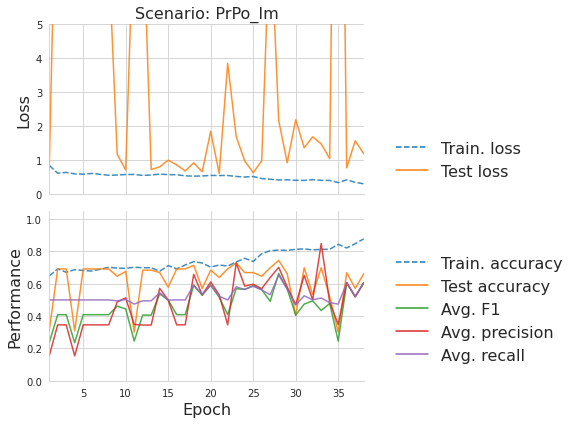

In [58]:
#RESNET_PATIENCE_7_TESTING_MODE  = "../../results/test-opt-cnn-performance-metrics-summary-resnet50-w-252-px-h252-px-patience-7-12-Aug-2021-16-55-48.csv"
INCEPTION_PATIENCE_10  = "../../results/opt-cnn-performance-metrics-summary-inception_v3-w-336-px-h336-21-Aug-2021-12-46-16-px.csv"
gg = plotCNNPerformanceMetrics(INCEPTION_PATIENCE_10, scenario = "PrPo_Im")

## 6 layer architecture, test set size=0.25, occlusion=0.3, pixel_level=True

In [67]:
results = {"../../results/opt-cnn-performance-metrics-summary-base-a-w-336-px-h336-08-Feb-2022-09-54-07-px.csv":"Pr_Im", 
           "../../results/opt-cnn-performance-metrics-summary-base-a-w-336-px-h336-08-Feb-2022-11-33-46-px.csv":"PrPo_Im", 
           "../../results/opt-cnn-performance-metrics-summary-base-a-w-336-px-h336-08-Feb-2022-14-12-11-px.csv":"Pr_PoIm", 
           "../../results/opt-cnn-performance-metrics-summary-base-a-w-336-px-h336-08-Feb-2022-15-59-22-px.csv":"Pr_Po_Im"}

base
base model ylimit set
base
base model ylimit set
base
base model ylimit set
base
base model ylimit set


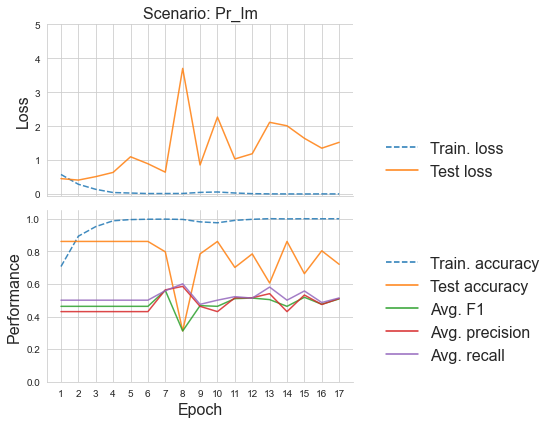

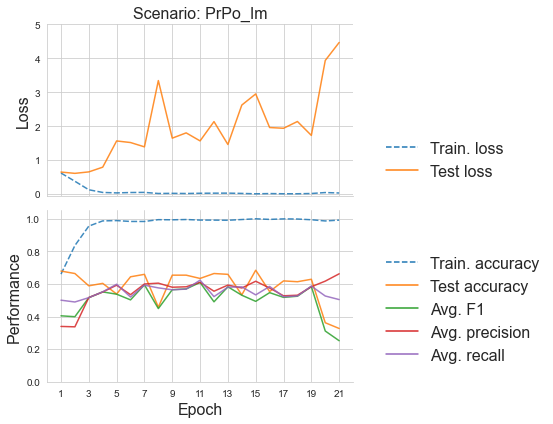

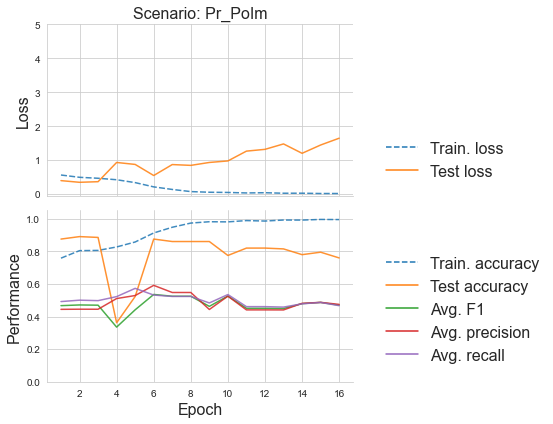

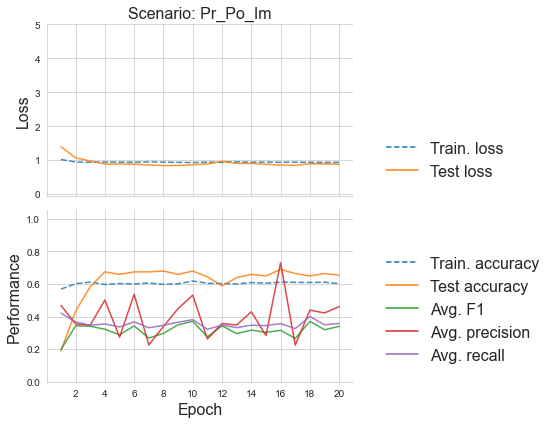

In [72]:
for r,s in results.items():
    plotCNNPerformanceMetrics(r,s)

### 5-layer architecture, test set size=0.25, occlusion=0.3, pixel_level=True

summary
base model ylimit set


,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,val_f1,val_recall,val_precision,Scenario,epoch
0,0,0.606742,0.669205,0.619910,0.678392,0.404192,0.500000,0.339196,PrPo_Im,1
1,1,0.326659,0.861816,0.623921,0.678392,0.404192,0.500000,0.339196,PrPo_Im,2
2,2,0.097086,0.969825,0.676066,0.668342,0.414706,0.496701,0.463462,PrPo_Im,3
3,3,0.060186,0.980541,1.028008,0.678392,0.418766,0.504109,0.590102,PrPo_Im,4
4,4,0.054302,0.979977,0.940663,0.663317,0.480742,0.517650,0.549289,PrPo_Im,5
5,5,0.035640,0.987028,1.439516,0.658291,0.503959,0.526273,0.554048,PrPo_Im,6
6,6,0.040048,0.987310,1.506498,0.557789,0.533958,0.546701,0.541131,PrPo_Im,7
7,7,0.055732,0.979695,1.195696,0.603015,0.557217,0.559491,0.556558,PrPo_Im,8
8,8,0.013479,0.997180,2.401388,0.653266,0.455141,0.502025,0.506341,PrPo_Im,9
9,9,0.010901,0.997744,2.251518,0.668342,0.463305,0.513137,0.550579,PrPo_Im,10


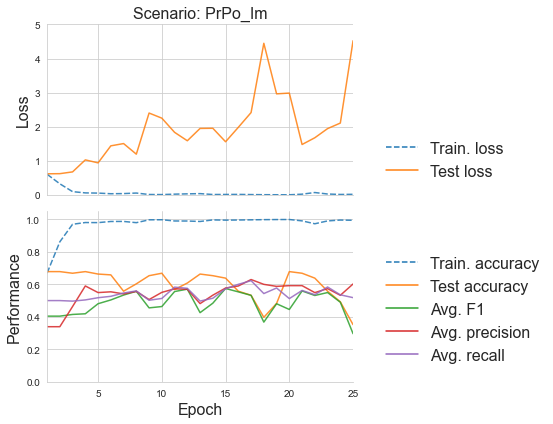

In [10]:
result_prpo_im = "../../results/opt-cnn-performance-metrics-summary-base-w-336-px-h336-14-Feb-2022-14-41-22-px.csv"
plotCNNPerformanceMetrics(result_prpo_im, scenario="PrPo_Im")

### 6-layer architecture, test set size=0.3, occlusion=0.3, pixel_level=True

summary
base model ylimit set


,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,val_f1,val_recall,val_precision,Scenario,epoch
0,0,0.602238,0.676311,0.649390,0.632911,0.387597,0.500000,0.316456,PrPo_Im,1
1,1,0.332388,0.866787,0.832240,0.632911,0.387597,0.500000,0.316456,PrPo_Im,2
2,2,0.124118,0.958409,0.739799,0.628692,0.406556,0.501494,0.516810,PrPo_Im,3
3,3,0.039048,0.991260,0.862631,0.632911,0.494546,0.531379,0.574645,PrPo_Im,4
4,4,0.029142,0.990958,2.691457,0.637131,0.399965,0.505747,0.817797,PrPo_Im,5
5,5,0.026416,0.992465,1.322581,0.594937,0.581149,0.588276,0.582818,PrPo_Im,6
6,6,0.057014,0.977095,2.886793,0.421941,0.392706,0.516782,0.530976,PrPo_Im,7
7,7,0.049742,0.982218,1.755309,0.616034,0.489478,0.520460,0.540701,PrPo_Im,8
8,8,0.030119,0.989753,1.801108,0.586498,0.573741,0.581609,0.576333,PrPo_Im,9
9,9,0.023097,0.992767,1.902154,0.599156,0.563197,0.562644,0.564319,PrPo_Im,10


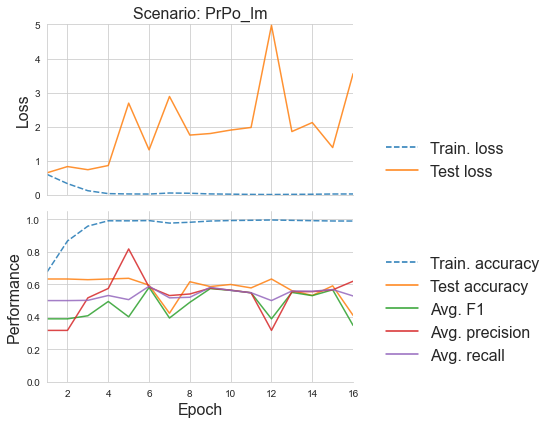

In [11]:
result_prpo_im = "../../results/opt-cnn-performance-metrics-summary-base-w-336-px-h336-15-Feb-2022-00-54-38-px.csv"
plotCNNPerformanceMetrics(result_prpo_im, scenario="PrPo_Im")

### 5-layer architecture, test set size=0.3, occlusion=0.3, pixel_level=True

summary
base model ylimit set


,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,val_f1,val_recall,val_precision,Scenario,epoch
0,0,0.623927,0.656721,0.651667,0.632911,0.387597,0.500000,0.316456,PrPo_Im,1
1,1,0.367713,0.838457,0.638534,0.624473,0.384416,0.493333,0.314894,PrPo_Im,2
2,2,0.136376,0.953285,1.144891,0.632911,0.387597,0.500000,0.316456,PrPo_Im,3
3,3,0.057084,0.982821,0.711244,0.611814,0.594480,0.599195,0.594241,PrPo_Im,4
4,4,0.045658,0.984629,0.971180,0.582278,0.578648,0.600000,0.593535,PrPo_Im,5
5,5,0.028834,0.993068,2.170511,0.485232,0.473755,0.564368,0.587318,PrPo_Im,6
6,6,0.030873,0.989451,1.273293,0.628692,0.605896,0.607701,0.604951,PrPo_Im,7
7,7,0.040092,0.986739,2.960176,0.637131,0.410243,0.508161,0.651709,PrPo_Im,8
8,8,0.063964,0.977697,2.257455,0.645570,0.451389,0.524483,0.655702,PrPo_Im,9
9,9,0.037188,0.986739,1.198383,0.628692,0.573880,0.573908,0.586270,PrPo_Im,10


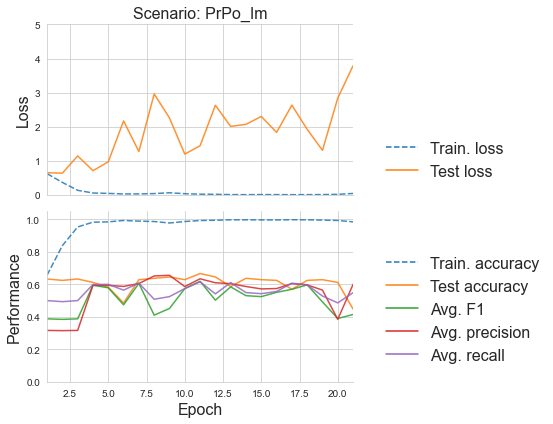

In [12]:
result_prpo_im = "../../results/opt-cnn-performance-metrics-summary-base-w-336-px-h336-15-Feb-2022-03-00-18-px.csv"
plotCNNPerformanceMetrics(result_prpo_im, scenario="PrPo_Im")

### ResNet test set size=0.3, occlusion=0.3, pixel_level=True

### Inception test set size=0.3, occlusion=0.3, pixel_level=True

## Augmentation - March, 2022

### horizontal flipping

summary
base model ylimit set
base model ylimit set
base model ylimit set


,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,val_f1,val_recall,val_precision,Scenario,epoch
0,0,0.756101,0.555024,0.631230,0.793233,0.442348,0.500000,0.396617,Pr_Im,1
1,1,0.581537,0.708134,0.595445,0.793233,0.442348,0.500000,0.396617,Pr_Im,2
2,2,0.486287,0.802632,0.532237,0.793233,0.442348,0.500000,0.396617,Pr_Im,3
3,3,0.343724,0.876794,0.515905,0.793233,0.442348,0.500000,0.396617,Pr_Im,4
4,4,0.243897,0.921053,0.521243,0.793233,0.442348,0.500000,0.396617,Pr_Im,5
5,5,0.761387,0.531068,0.679666,0.637143,0.504675,0.554213,0.665625,PrPo_Im,1
6,6,0.617935,0.654369,0.680312,0.640000,0.584417,0.589723,0.618745,PrPo_Im,2
7,7,0.554246,0.721359,0.665779,0.602857,0.376114,0.500000,0.301429,PrPo_Im,3
8,8,0.451277,0.795146,0.662206,0.608571,0.397999,0.508422,0.678468,PrPo_Im,4
9,9,0.356973,0.856311,0.737034,0.602857,0.376114,0.500000,0.301429,PrPo_Im,5


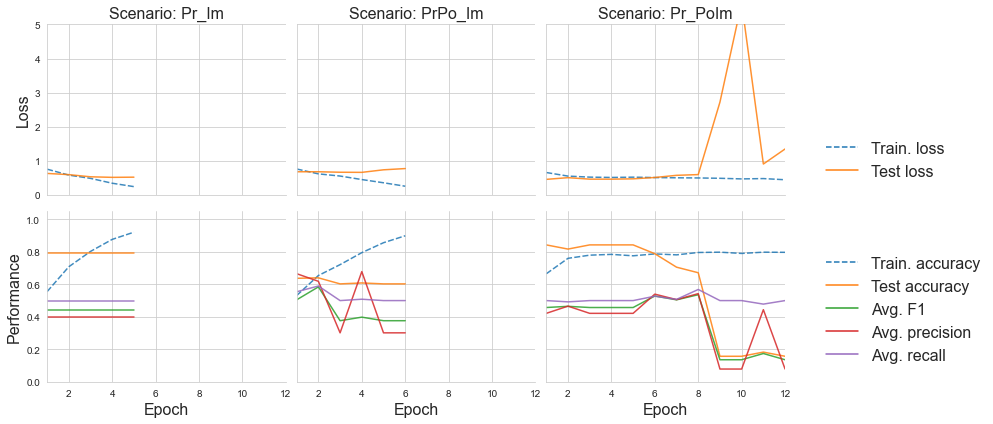

In [12]:
results = "../../results/opt-cnn-performance-metrics-summary-base-w-336-px-h336-px-fliplr28-Feb-2022-01-33-43.csv"
plotCNNPerformanceMetrics(results, scenario="Pr_Im, PrPo_Im, Pr_PoIm")

### Horizontal flipping, Occlusion on all training images

summary
base model ylimit set
base model ylimit set
base model ylimit set


,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,val_f1,val_recall,val_precision,Scenario,epoch
0,0,0.788966,0.538278,0.650828,0.796992,0.477521,0.515812,0.732573,Pr_Im,1
1,1,0.577491,0.712919,0.592410,0.793233,0.442348,0.500000,0.396617,Pr_Im,2
2,2,0.473284,0.800239,0.558545,0.793233,0.442348,0.500000,0.396617,Pr_Im,3
3,3,0.360094,0.857656,0.503477,0.793233,0.442348,0.500000,0.396617,Pr_Im,4
4,4,0.215633,0.933014,0.496959,0.793233,0.442348,0.500000,0.396617,Pr_Im,5
5,5,0.722003,0.576699,0.681770,0.602857,0.376114,0.500000,0.301429,PrPo_Im,1
6,6,0.600974,0.673786,0.669022,0.602857,0.376114,0.500000,0.301429,PrPo_Im,2
7,7,0.506797,0.752427,0.675400,0.637143,0.586015,0.589809,0.614244,PrPo_Im,3
8,8,0.398896,0.833010,0.657261,0.602857,0.376114,0.500000,0.301429,PrPo_Im,4
9,9,0.261687,0.891262,0.659316,0.594286,0.385540,0.495346,0.443149,PrPo_Im,5


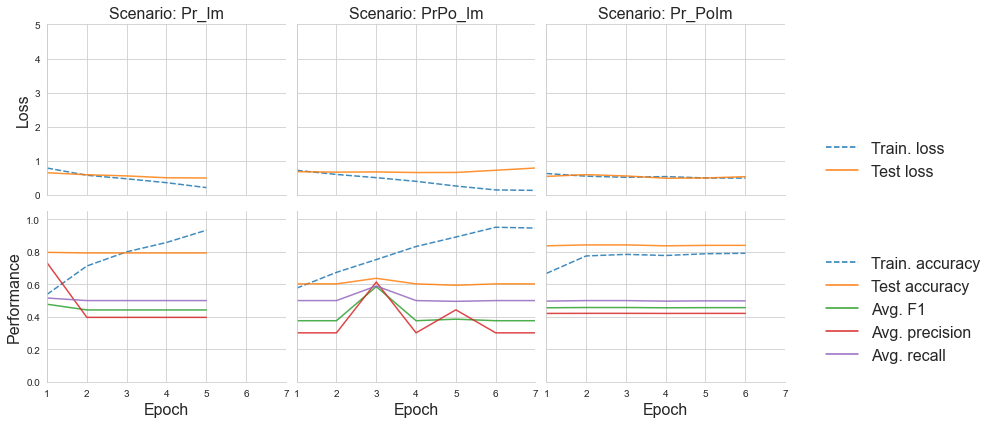

In [13]:
results = "../../results/opt-cnn-performance-metrics-summary-base-w-336-px-h336-px-occlusion_all28-Feb-2022-02-46-42.csv"
plotCNNPerformanceMetrics(results, scenario="Pr_Im, PrPo_Im, Pr_PoIm")

### Horizontal flipping, Occlusion on half of training images

base
base model ylimit set
base model ylimit set
base model ylimit set


,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,val_f1,val_recall,val_precision,Scenario,epoch
0,0,0.773083,0.549043,0.816890,0.206767,0.171340,0.500000,0.103383,Pr_Im,1
1,1,0.647722,0.644737,0.576768,0.793233,0.442348,0.500000,0.396617,Pr_Im,2
2,2,0.524150,0.744019,0.537893,0.793233,0.442348,0.500000,0.396617,Pr_Im,3
3,3,0.396676,0.840909,0.504881,0.793233,0.442348,0.500000,0.396617,Pr_Im,4
4,4,0.284828,0.904306,0.495214,0.793233,0.442348,0.500000,0.396617,Pr_Im,5
5,5,0.202823,0.935407,0.535148,0.793233,0.442348,0.500000,0.396617,Pr_Im,6
6,6,0.745851,0.569903,0.682471,0.608571,0.500162,0.535426,0.571675,PrPo_Im,1
7,7,0.622083,0.661165,0.668299,0.602857,0.376114,0.500000,0.301429,PrPo_Im,2
8,8,0.526076,0.738835,0.665772,0.602857,0.376114,0.500000,0.301429,PrPo_Im,3
9,9,0.404650,0.818447,0.661590,0.600000,0.381594,0.498858,0.467819,PrPo_Im,4


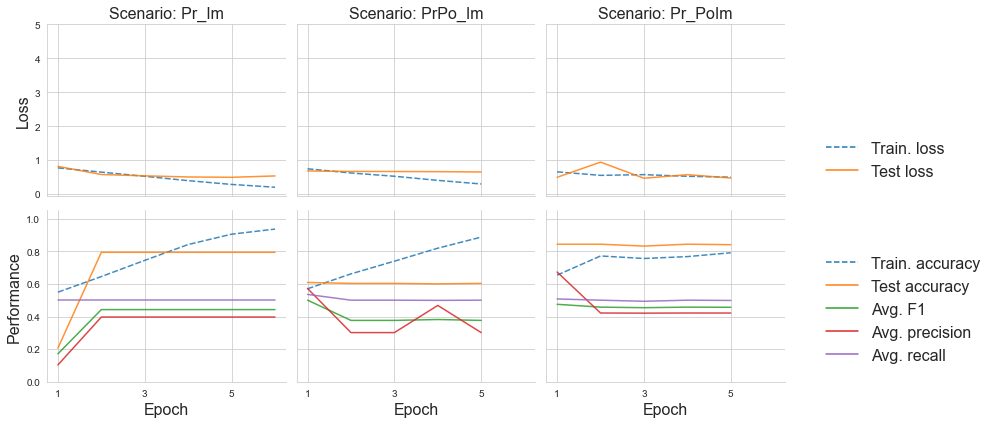

In [14]:
results = "../../results/opt-cnn-performance-metrics-summary-base-w-336-px-h336-px-occlusion_half-28-Feb-2022-03-32-27.csv"
plotCNNPerformanceMetrics(results, scenario="Pr_Im, PrPo_Im, Pr_PoIm")

### Occlusion to double training

base
base model ylimit set
base model ylimit set
base model ylimit set


,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,val_f1,val_recall,val_precision,Scenario,epoch
0,0,0.723266,0.584928,0.777664,0.206767,0.171340,0.500000,0.103383,Pr_Im,1
1,1,0.512592,0.761962,0.588345,0.793233,0.442348,0.500000,0.396617,Pr_Im,2
2,2,0.292438,0.900718,0.515998,0.793233,0.442348,0.500000,0.396617,Pr_Im,3
3,3,0.152617,0.959330,0.494857,0.793233,0.442348,0.500000,0.396617,Pr_Im,4
4,4,0.081711,0.986842,0.500652,0.793233,0.442348,0.500000,0.396617,Pr_Im,5
5,5,0.050243,0.990431,0.578041,0.793233,0.442348,0.500000,0.396617,Pr_Im,6
6,6,0.694311,0.608738,0.683749,0.622857,0.579832,0.581643,0.596362,PrPo_Im,1
7,7,0.488879,0.777670,0.664551,0.602857,0.376114,0.500000,0.301429,PrPo_Im,2
8,8,0.234148,0.927184,0.650139,0.605714,0.383929,0.503597,0.802292,PrPo_Im,3
9,9,0.092010,0.976699,0.646970,0.614286,0.406787,0.514388,0.804913,PrPo_Im,4


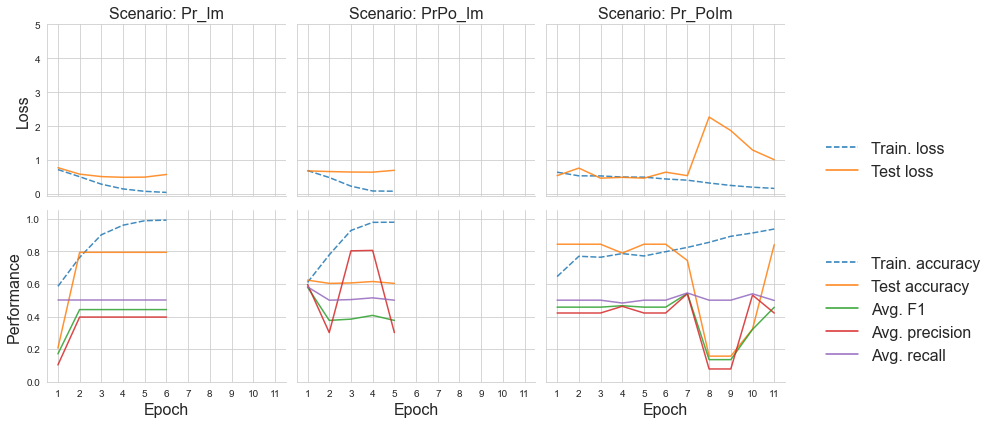

In [15]:
results = "../../results/opt-cnn-performance-metrics-summary-base-w-336-px-h336-px-occlusion_double-28-Feb-2022-12-54-03.csv"
plotCNNPerformanceMetrics(results, scenario="Pr_Im, PrPo_Im, Pr_PoIm")

inception_v3
base model ylimit set
base model ylimit set
base model ylimit set


,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,val_f1,val_recall,val_precision,Scenario,epoch
0,0,0.759167,0.721292,0.511587,0.793233,0.442348,0.5,0.396617,Pr_Im,1
1,1,0.530182,0.766746,0.528245,0.793233,0.442348,0.5,0.396617,Pr_Im,2
2,2,0.461567,0.782297,1.255146,0.793233,0.442348,0.5,0.396617,Pr_Im,3
3,3,0.458053,0.790670,0.697472,0.793233,0.442348,0.5,0.396617,Pr_Im,4
4,4,0.461699,0.773923,1.059270,0.793233,0.442348,0.5,0.396617,Pr_Im,5
5,5,0.858352,0.576699,0.923441,0.602857,0.376114,0.5,0.301429,PrPo_Im,1
6,6,0.640290,0.641748,1.970733,0.602857,0.376114,0.5,0.301429,PrPo_Im,2
7,7,0.652476,0.627184,2.826432,0.602857,0.376114,0.5,0.301429,PrPo_Im,3
8,8,0.629218,0.643689,3.272381,0.602857,0.376114,0.5,0.301429,PrPo_Im,4
9,9,0.630305,0.660194,3.339570,0.602857,0.376114,0.5,0.301429,PrPo_Im,5


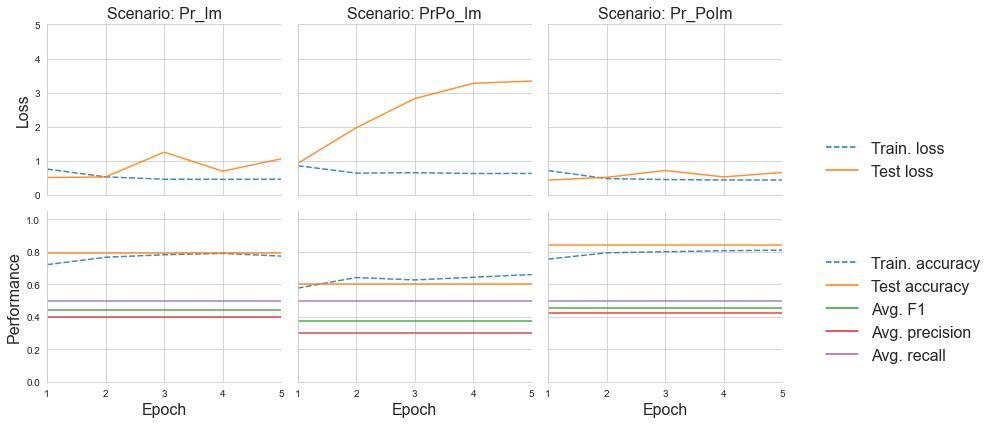

In [26]:
s = "../../results/opt-cnn-performance-metrics-summary-inception_v3-w-336-px-h-336-px-occlusion_all-02-Mar-2022-02-45-11.csv"
plotCNNPerformanceMetrics(s, "Pr_Im,PrPo_Im,Pr_PoIm")

base
base model ylimit set
base model ylimit set
base model ylimit set
base model ylimit set


,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,val_f1,val_recall,val_precision,Scenario,epoch
0,0,0.967646,0.513158,0.780720,0.206767,0.171340,0.500000,0.103383,Pr_Im,1
1,1,0.790272,0.552632,0.592794,0.793233,0.442348,0.500000,0.396617,Pr_Im,2
2,2,0.625785,0.693780,0.576764,0.793233,0.442348,0.500000,0.396617,Pr_Im,3
3,3,0.588057,0.728469,0.560041,0.793233,0.442348,0.500000,0.396617,Pr_Im,4
4,4,0.571144,0.761962,0.553926,0.793233,0.442348,0.500000,0.396617,Pr_Im,5
5,5,0.519519,0.766746,0.543109,0.793233,0.442348,0.500000,0.396617,Pr_Im,6
6,6,0.539172,0.763158,0.531923,0.793233,0.442348,0.500000,0.396617,Pr_Im,7
7,7,0.492497,0.797847,0.532675,0.793233,0.442348,0.500000,0.396617,Pr_Im,8
8,8,0.440548,0.830144,0.512761,0.793233,0.442348,0.500000,0.396617,Pr_Im,9
9,9,0.389468,0.834928,0.510223,0.793233,0.459649,0.506721,0.647727,Pr_Im,10


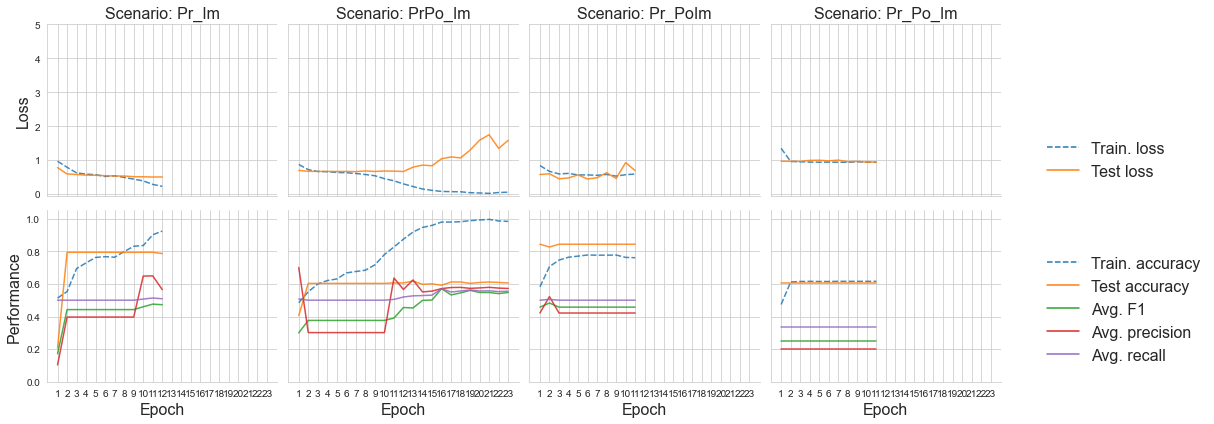

In [15]:
s = "../../results/opt-cnn-performance-metrics-summary-base-w-336-px-h-336-px-occlusion_all-06-Mar-2022-01-15-58.csv"
plotCNNPerformanceMetrics(s)

base
base model ylimit set
base model ylimit set
base model ylimit set
base model ylimit set


,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,val_f1,val_recall,val_precision,Scenario,epoch
0,0,0.816436,0.537081,0.590243,0.793233,0.475759,0.513442,0.648855,Pr_Im,1
1,1,0.637515,0.627990,0.514714,0.785714,0.472277,0.508703,0.564744,Pr_Im,2
2,2,0.528369,0.740431,0.510454,0.793233,0.442348,0.500000,0.396617,Pr_Im,3
3,3,0.409017,0.813397,0.484556,0.793233,0.442348,0.500000,0.396617,Pr_Im,4
4,4,0.254792,0.910287,0.484953,0.793233,0.442348,0.500000,0.396617,Pr_Im,5
...,...,...,...,...,...,...,...,...,...,...
65,65,0.941635,0.594175,0.973399,0.600000,0.257902,0.334142,0.368015,Pr_Po_Im,15
66,66,0.924303,0.599029,1.016224,0.585714,0.324759,0.360294,0.503548,Pr_Po_Im,16
67,67,0.935839,0.615534,0.956232,0.597143,0.281686,0.341820,0.479351,Pr_Po_Im,17
68,68,0.942805,0.600971,0.974346,0.602857,0.272976,0.340499,0.369396,Pr_Po_Im,18


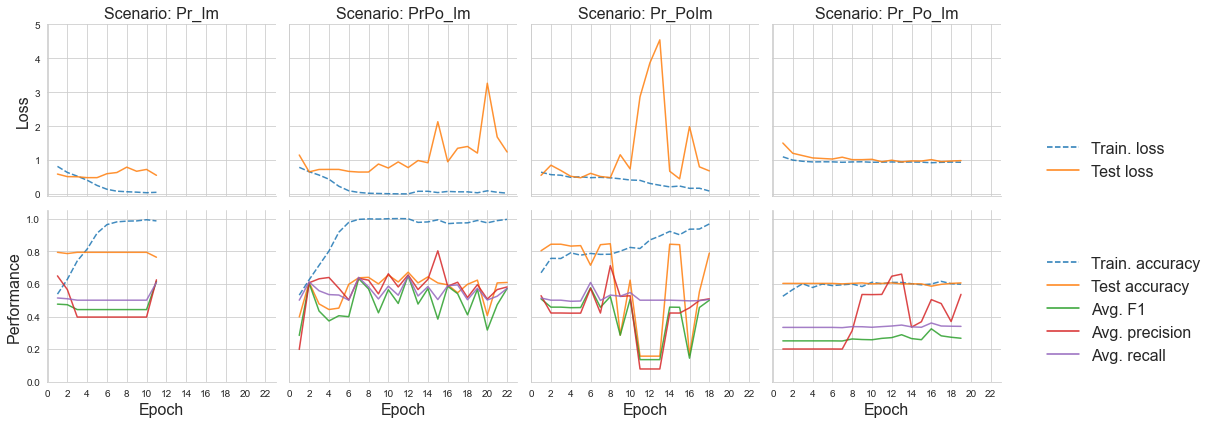

In [10]:
s = "../../results/opt-cnn-performance-metrics-summary-base-w-336-px-h-336-px-occlusion_all-06-Mar-2022-13-12-20.csv"
plotCNNPerformanceMetrics(s)

base
base model ylimit set
base model ylimit set
base model ylimit set


,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,val_f1,val_recall,val_precision,Scenario,epoch
0,0,0.831943,0.533493,0.550153,0.774436,0.452299,0.494873,0.467181,Pr_Im,1
1,1,0.648620,0.644737,3.225943,0.206767,0.171340,0.500000,0.103383,Pr_Im,2
2,2,0.538581,0.727273,5.058449,0.206767,0.171340,0.500000,0.103383,Pr_Im,3
3,3,0.346183,0.851675,0.586077,0.725564,0.578849,0.578328,0.579403,Pr_Im,4
4,4,0.175494,0.937799,1.144704,0.218045,0.186975,0.507109,0.604563,Pr_Im,5
5,5,0.159372,0.952153,0.730041,0.522556,0.501233,0.611676,0.575524,Pr_Im,6
6,6,0.114254,0.966507,0.693752,0.624060,0.580177,0.662215,0.606809,Pr_Im,7
7,7,0.064213,0.985646,1.441879,0.214286,0.181803,0.504739,0.604167,Pr_Im,8
8,8,0.790829,0.506796,0.672907,0.588571,0.431434,0.501654,0.505561,PrPo_Im,1
9,9,0.642472,0.653398,1.116021,0.397143,0.284254,0.500000,0.198571,PrPo_Im,2


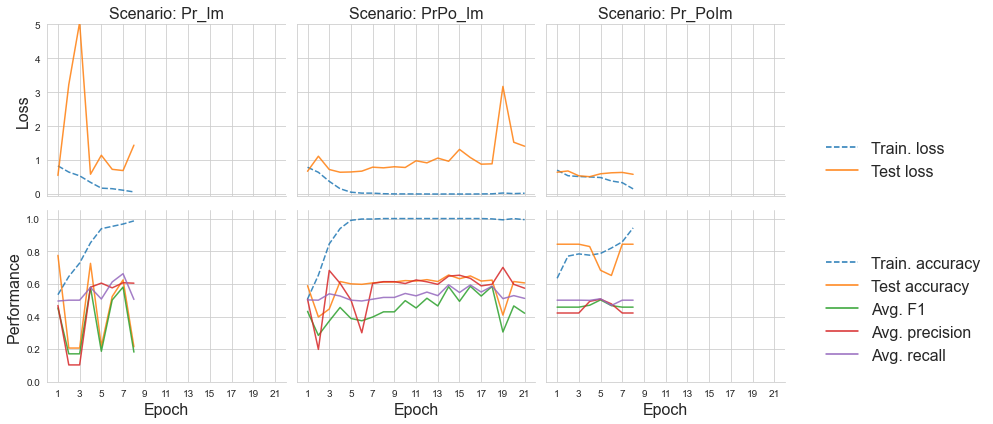

In [17]:
s = "../../results/opt-cnn-performance-metrics-summary-base-w-336-px-h-336-px-occlusion_all-07-Mar-2022-01-54-43.csv"
plotCNNPerformanceMetrics(s, "Pr_Im,PrPo_Im,Pr_PoIm")

base
base model ylimit set
base model ylimit set
base model ylimit set


,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,val_f1,val_recall,val_precision,Scenario,epoch
0,0,0.710466,0.562201,0.658079,0.793233,0.442348,0.500000,0.396617,Pr_Im,1
1,1,0.570986,0.702153,0.573938,0.793233,0.442348,0.500000,0.396617,Pr_Im,2
2,2,0.483303,0.791866,0.524298,0.793233,0.442348,0.500000,0.396617,Pr_Im,3
3,3,0.416945,0.822967,0.502874,0.793233,0.442348,0.500000,0.396617,Pr_Im,4
4,4,0.329593,0.869617,0.505192,0.793233,0.442348,0.500000,0.396617,Pr_Im,5
5,5,0.289533,0.885167,0.555799,0.793233,0.442348,0.500000,0.396617,Pr_Im,6
6,6,0.237669,0.910287,0.511873,0.793233,0.442348,0.500000,0.396617,Pr_Im,7
7,7,0.156576,0.943780,0.483797,0.793233,0.442348,0.500000,0.396617,Pr_Im,8
8,8,0.120190,0.965311,0.743704,0.793233,0.442348,0.500000,0.396617,Pr_Im,9
9,9,0.095823,0.968900,0.752763,0.793233,0.442348,0.500000,0.396617,Pr_Im,10


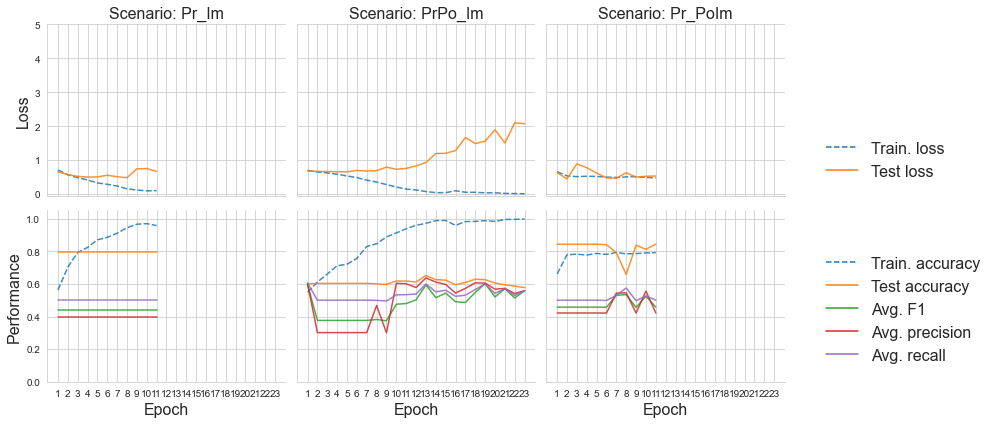

In [19]:
s = "../../results/opt-cnn-performance-metrics-summary-base-w-336-px-h-336-px-occlusion_all-07-Mar-2022-22-42-39.csv"
plotCNNPerformanceMetrics(s, "Pr_Im,PrPo_Im,Pr_PoIm")

base
base model ylimit set
base model ylimit set
base model ylimit set


,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,val_f1,val_recall,val_precision,Scenario,epoch
0,0,0.810652,0.570574,0.619653,0.785714,0.513337,0.528867,0.609908,Pr_Im,1
1,1,0.684486,0.607656,0.681767,0.571429,0.543313,0.649203,0.598689,Pr_Im,2
2,2,0.542837,0.746412,0.497376,0.793233,0.442348,0.500000,0.396617,Pr_Im,3
3,3,0.441448,0.797847,0.511028,0.793233,0.442348,0.500000,0.396617,Pr_Im,4
4,4,0.303200,0.869617,0.495988,0.793233,0.442348,0.500000,0.396617,Pr_Im,5
5,5,0.179385,0.956938,0.529526,0.793233,0.442348,0.500000,0.396617,Pr_Im,6
6,6,0.125055,0.978469,0.514386,0.793233,0.442348,0.500000,0.396617,Pr_Im,7
7,7,0.075962,0.979665,0.506880,0.793233,0.442348,0.500000,0.396617,Pr_Im,8
8,8,0.052870,0.990431,0.678603,0.793233,0.442348,0.500000,0.396617,Pr_Im,9
9,9,0.076563,0.980861,0.732432,0.793233,0.442348,0.500000,0.396617,Pr_Im,10


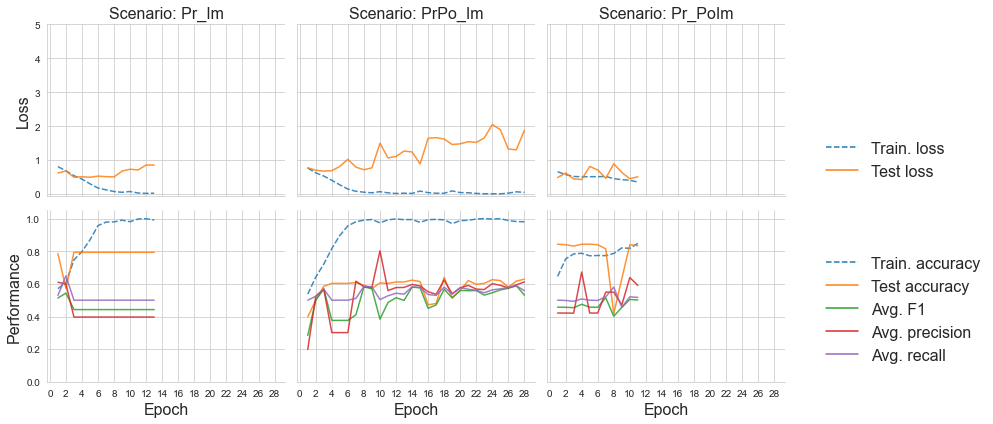

In [22]:
s = "../../results/opt-cnn-performance-metrics-summary-base-w-336-px-h-336-px-occlusion_all-08-Mar-2022-01-56-39.csv"
plotCNNPerformanceMetrics(s, "Pr_Im,PrPo_Im,Pr_PoIm")

base
base model ylimit set
base model ylimit set
base model ylimit set


,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,val_f1,val_recall,val_precision,Scenario,epoch
0,0,0.772521,0.545455,0.739385,0.236842,0.223397,0.478630,0.449593,Pr_Im,1
1,1,0.654053,0.637560,0.599153,0.793233,0.442348,0.500000,0.396617,Pr_Im,2
2,2,0.567162,0.700957,0.559949,0.793233,0.442348,0.500000,0.396617,Pr_Im,3
3,3,0.464161,0.805024,0.510642,0.793233,0.442348,0.500000,0.396617,Pr_Im,4
4,4,0.388977,0.830144,0.504340,0.793233,0.442348,0.500000,0.396617,Pr_Im,5
5,5,0.320351,0.874402,0.499588,0.793233,0.442348,0.500000,0.396617,Pr_Im,6
6,6,0.243358,0.907895,0.592559,0.793233,0.442348,0.500000,0.396617,Pr_Im,7
7,7,0.168292,0.943780,0.567713,0.793233,0.442348,0.500000,0.396617,Pr_Im,8
8,8,0.145533,0.955742,0.522871,0.793233,0.442348,0.500000,0.396617,Pr_Im,9
9,9,0.114219,0.960526,0.564414,0.793233,0.442348,0.500000,0.396617,Pr_Im,10


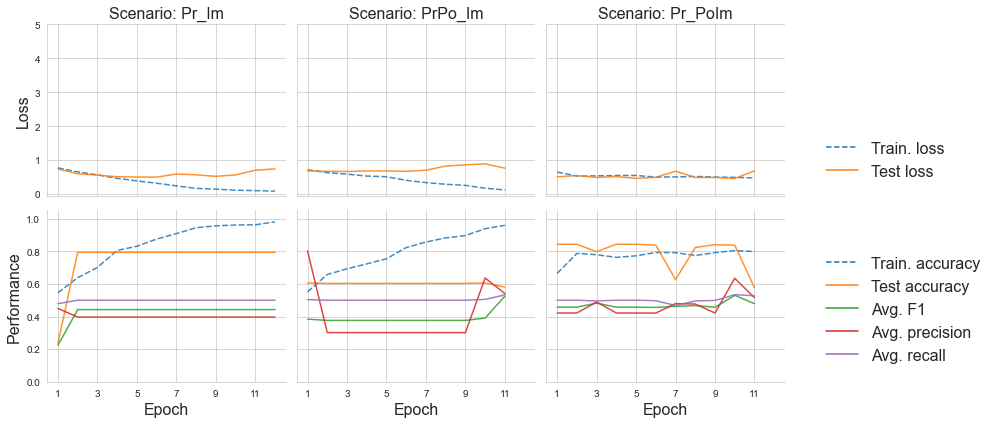

In [24]:
s = "../../results/opt-cnn-performance-metrics-summary-base-w-336-px-h-336-px-occlusion_all-08-Mar-2022-09-49-17.csv"
plotCNNPerformanceMetrics(s, "Pr_Im,PrPo_Im,Pr_PoIm")